In [1]:
%load_ext autoreload
%autoreload 2

import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Compose, Normalize, Lambda, Resize

device = 'cuda'

In [2]:
from data import CatDataset
from diffusion import Diffusion, get_named_beta_schedule
from trainer import Trainer
from models.unet import UNet

/home/xallt/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds = CatDataset(
    'data/cats_256_aligned',
    transform = Compose([
        Lambda(lambda x: x.float()),
        Resize(32),
        Normalize(127.5, 127.5),
    ])
)

/media/xallt/HardDrive/.virtualenv/catgen/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


sample.shape torch.Size([3, 32, 32])
sample.min() tensor(-0.9804)
sample.max() tensor(1.)


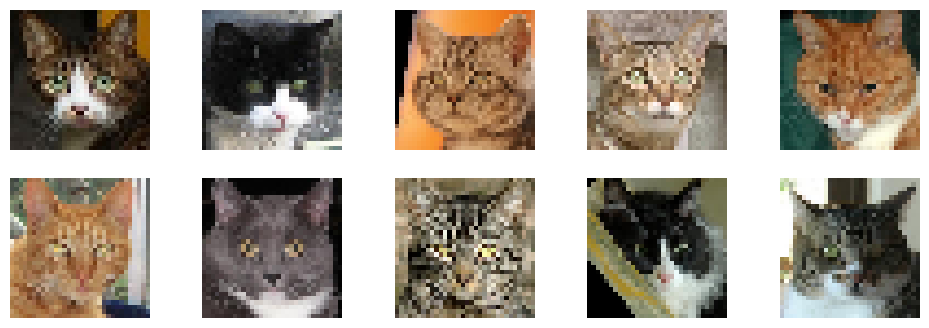

In [4]:
# Inspect dataset
indices = np.random.choice(len(ds), 10, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in zip(indices, axes.flatten()):
    ax.imshow(ds[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
    ax.axis('off')

sample = ds[0]
print("sample.shape", sample.shape)
print("sample.min()", sample.min())
print("sample.max()", sample.max())


In [20]:
from models.vae import Encoder, Decoder, VAE

In [48]:
model = VAE(3, 32, 3, 128)

In [49]:
inp = torch.randn(1, 3, 32, 32)

In [51]:
model.encoder.fc_mu

Linear(in_features=2048, out_features=128, bias=True)

In [50]:
model.encoder(inp)

torch.Size([1, 128, 4, 4])
torch.Size([1, 2048])


(tensor([[-0.6805,  0.4248, -0.4243,  0.3794,  0.2492, -0.3017,  0.3912, -0.2126,
          -0.4716, -0.1897, -0.2710,  0.0790, -0.4299,  0.0446,  0.1861,  0.2807,
          -0.3638,  0.5016, -0.5724, -0.2429, -0.1517,  0.2181,  0.1926, -0.3140,
          -0.4053, -0.3525,  0.1054, -0.0419, -0.1979,  0.2386, -0.2629, -0.0427,
           0.4533, -0.3376,  0.3059,  0.2543,  0.1310,  0.4076,  0.0451,  0.3579,
           0.1273, -0.3628,  0.1264, -0.0141,  0.8141, -0.2242,  0.4587,  0.3268,
           0.1547,  0.5194, -0.1826, -0.3249, -0.1027,  0.1529, -0.4201,  0.3021,
          -0.2824,  0.1176,  0.0673,  0.0419, -0.5910, -0.1108, -0.8649, -0.0244,
           0.1082, -0.2170,  0.1078, -0.0030, -0.1970, -0.1434,  0.2901,  0.4958,
          -0.5494,  0.2532,  0.4501,  0.1752,  0.4308, -0.2757, -0.2455, -0.2562,
          -0.5394, -0.0407,  0.3754,  0.2630,  0.0840,  0.0864,  0.3789,  0.2490,
          -0.1758, -0.5045, -0.2609,  0.2662,  0.4647, -0.0494,  0.3841, -0.1660,
          -0.153

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("model parameters", count_parameters(diffusion))

model parameters 499


In [15]:
trainer = Trainer(
    diffusion,
    ds.train_loader(batch_size=6),
    lr=1e-3,
    weight_decay=1e-4,
    num_epochs=100000,
    log_every=1,
    save_every=100,
    device='cuda',
    checkpoint_file='checkpoints/checkpoint.pt'
)

In [12]:
trainer.run_loop(True)

  0%|          | 0/1332 [00:00<?, ?it/s]/media/xallt/HardDrive/.virtualenv/catgen/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  5%|▌         | 67/1332 [00:02<00:45, 28.11it/s]


KeyboardInterrupt: 

# Debug

In [11]:
model.eval()
x0 = ds[0][None].to(device)
noise = torch.randn_like(x0)
t = torch.tensor([500]).to(device).long()
x_t = diffusion.q_sample(x0, t, noise)
with torch.no_grad():
    x0_hat = model(x_t, t)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


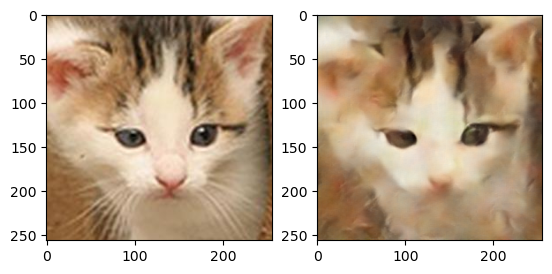

In [13]:
plt.subplot(1, 2, 1)
plt.imshow(x0[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
plt.subplot(1, 2, 2)
plt.imshow(x0_hat[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)

In [15]:
res = diffusion.p_sample_loop(model, (1, 3, 256, 256), device='cuda')

100%|██████████| 1000/1000 [00:25<00:00, 39.82it/s]


In [17]:
res.min(), res.max()

(tensor(-1.1973, device='cuda:0'), tensor(0.4419, device='cuda:0'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


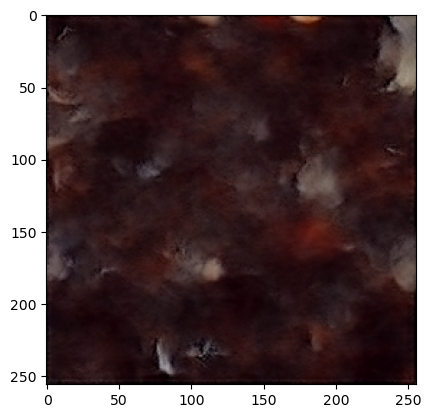

In [16]:
plt.imshow(res[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)